In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display
import random
import math
import tensorflow as tf
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras import backend, models
from sklearn.metrics import confusion_matrix

from tensorflow.keras.applications import VGG16, MobileNet
from keras.applications.vgg16 import preprocess_input

In [2]:
BASE_DIR = 'dataset'
print('BASE_DIR contains ', os.listdir(BASE_DIR))
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALIDATION_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

BASE_DIR contains  ['test', 'train', 'valid']


In [3]:
CATEGORIES = os.listdir(TRAIN_DIR)

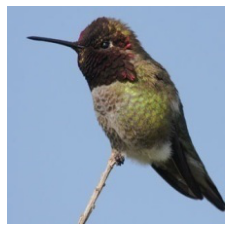

Figures are  (224, 224, 3)


In [4]:
IMAGE = load_img("dataset/train/ANNAS HUMMINGBIRD/025.jpg")
plt.imshow(IMAGE)
plt.axis("off")
plt.show()

IMAGEDATA = img_to_array(IMAGE)
SHAPE = IMAGEDATA.shape
print('Figures are ', SHAPE)

In [5]:
General_datagen = ImageDataGenerator(rescale=1./255, )

In [6]:
train_data = General_datagen.flow_from_directory(TRAIN_DIR, target_size=(224,224))
print('data groups:', len(train_data))
Train_groups = len(train_data)
print(Train_groups)
validation_data = General_datagen.flow_from_directory(VALIDATION_DIR, target_size=(224,224),)
image_qty = len(validation_data.filenames)
print('data groups:', len(validation_data))
print('validation image qty:',str(image_qty))
Valid_groups = len(validation_data)
test_data = General_datagen.flow_from_directory(TEST_DIR, target_size=(224,224),)
print('data groups:', len(test_data))

Found 35215 images belonging to 250 classes.
data groups: 1101
1101
Found 1250 images belonging to 250 classes.
data groups: 40
validation image qty: 1250
Found 1250 images belonging to 250 classes.
data groups: 40


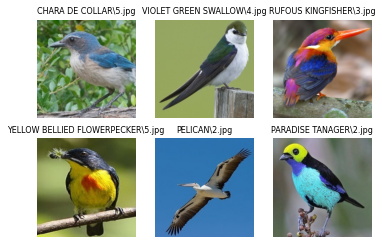

In [7]:
def label_images2(DIR, dataset):
    label = []
    image = []
    j=0
    for i in range (0,30):
        j = random.randint(0, len(dataset.filenames))
        label.append(dataset.filenames[j].split('/')[0])
        image.append(DIR + '/' + dataset.filenames[j])
    return [label,image]


y,x = label_images2(TEST_DIR, test_data)

for i in range(0,6):
    X = load_img(x[i])
    plt.subplot(2,3,+1 + i)
    plt.axis(False)
    plt.title(y[i], fontsize=8)
    plt.imshow(X)
plt.show()

# -----------------------------------

In [8]:
backend.clear_session()
base_mobilenet = MobileNet(weights = 'imagenet', include_top = False, 
                           input_shape = SHAPE)
base_mobilenet.trainable = False

model = Sequential()
model.add(base_mobilenet)
model.add(Conv2D(64,(7,7),input_shape=(224,224,3),padding='same'))
model.add(Activation('tanh'))
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Flatten())
model.add(Dense(32*32))
model.add(Dropout(0.1))
model.add(Dense(250))
model.add(Activation('softmax'))
model.summary()

#Compile
model.compile(Adam(0.0001),loss = 'categorical_crossentropy',metrics = ['accuracy'])

# ------------------------------------------------------------------------------------------------------

from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from datetime import datetime

mc = ModelCheckpoint('best_model_projeto3.h5', monitor='val_loss', mode='min', save_best_only=True)

# ------------------------------------------------------------------------------------------------------

history = model.fit_generator( 
    train_data, 
    steps_per_epoch = Train_groups, 
    epochs = 50,
    validation_data = validation_data,
    validation_steps = Valid_groups,
    verbose = 1,
    callbacks=[EarlyStopping(monitor = 'val_accuracy', patience = 5, 
                             restore_best_weights = True),
               ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7,
                                 patience = 2, verbose = 1),
               mc
    ]) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 64)          3211328   
_________________________________________________________________
activation (Activation)      (None, 7, 7, 64)          0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0

C:\Users\osodr\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1101/1101 [==============================] - 428s 388ms/step - loss: 3.3400 - accuracy: 0.3537 - val_loss: 0.5552 - val_accuracy: 0.8672
Epoch 2/50
1101/1101 [==============================] - 421s 382ms/step - loss: 0.3952 - accuracy: 0.9145 - val_loss: 0.3864 - val_accuracy: 0.8944
Epoch 3/50
1101/1101 [==============================] - 422s 383ms/step - loss: 0.1232 - accuracy: 0.9801 - val_loss: 0.3128 - val_accuracy: 0.9104
Epoch 4/50
1101/1101 [==============================] - 421s 382ms/step - loss: 0.0478 - accuracy: 0.9951 - val_loss: 0.2785 - val_accuracy: 0.9160
Epoch 5/50
1101/1101 [==============================] - 424s 385ms/step - loss: 0.0278 - accuracy: 0.9977 - val_loss: 0.3179 - val_accuracy: 0.9048
Epoch 6/50
1101/1101 [==============================] - 423s 384ms/step - loss: 0.0798 - accuracy: 0.9827 - val_loss: 0.3664 - val_accuracy: 0.8840

Epoch 00006: ReduceLROnPlateau reducing learning rate to 6.999999823165126e-05.
Epoch 7/50
1101/1101 [====================

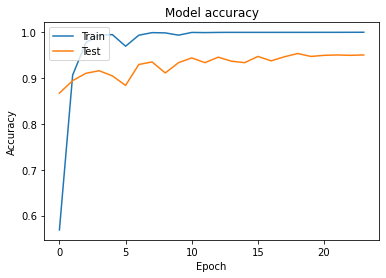

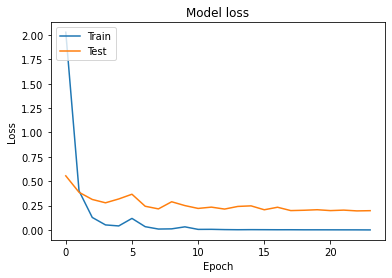

40/40 [==============================] - 13s 312ms/step - loss: 0.1216 - accuracy: 0.9656
Test loss: 0.12158472836017609
Test accuracy: 0.9656000137329102


In [9]:
#plot accuracy vs epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss values vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate against test data.
scores = model.evaluate(test_data, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [10]:
dic=train_data.class_indices
icd={k:v for v,k in dic.items()}
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict_classes(img)
    probability=round(np.max(model.predict_proba(img)*100),2)
    print (probability, ' % chances are there that the Bird Is',icd[answer[0]])

C:\Users\osodr\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


99.99  % chances are there that the Bird Is BANANAQUIT


C:\Users\osodr\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


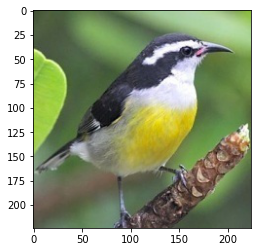

In [11]:
img="dataset/valid/BANANAQUIT/4.jpg"
pic=load_img(img,target_size=(224,224,3))
plt.imshow(pic)
output(img)

In [12]:
np.save('my_history2.npy',history.history)

In [13]:
history2=np.load('my_history2.npy',allow_pickle='TRUE').item()

In [14]:
# Para não ter que correr o model.fit de novo
import h5py
from keras.models import load_model
model = load_model('best_model_projeto3.h5')

In [15]:
dic=train_data.class_indices
icd={k:v for v,k in dic.items()}
def output2(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict_classes(img)
    probability=round(np.max(model.predict_proba(img)*100),2)
    return (probability,icd[answer[0]],location.replace("dataset/valid/",""))

# Classificação de todas as aves

In [16]:
import os

folder = "dataset/valid/"
paths = [os.path.join(root,filename) for root, directories, filenames in os.walk(folder) for filename in filenames]

a = []
counter = 0
for img in paths:
    pic=load_img(img,target_size=(224,224,3))
    a.append(output2(img))
    counter += 1
    if(counter % 50 == 0):
        print(f'{counter}/{len(paths)}')

50/1250
100/1250
150/1250
200/1250
250/1250
300/1250
350/1250
400/1250
450/1250
500/1250
550/1250
600/1250
650/1250
700/1250
750/1250
800/1250
850/1250
900/1250
950/1250
1000/1250
1050/1250
1100/1250
1150/1250
1200/1250
1250/1250


## Resultado

Podemos ver abaixo uma lista cuja estrutura é definida da seguinte forma:

- Chance de ser a espécie prevista
- Espécie prevista
- Verdadeira espécie

In [17]:
a_sorted = sorted(a)
print(a_sorted)

[(18.61, 'AFRICAN FIREFINCH', 'COMMON HOUSE MARTIN\\1.jpg'), (24.88, 'AMERICAN PIPIT', 'AMERICAN PIPIT\\2.jpg'), (27.49, 'RED HEADED WOODPECKER', 'GILA WOODPECKER\\4.jpg'), (28.58, 'NORTHERN PARULA', 'CAPE MAY WARBLER\\3.jpg'), (29.51, 'SUPERB STARLING', 'COMMON GRACKLE\\1.jpg'), (38.67, 'LEARS MACAW', 'PURPLE GALLINULE\\1.jpg'), (40.28, 'GUINEA TURACO', 'NORTHERN CARDINAL\\4.jpg'), (40.49, 'MALLARD DUCK', 'MALLARD DUCK\\1.jpg'), (41.01, 'YELLOW CACIQUE', 'HELMET VANGA\\2.jpg'), (41.13, 'HOUSE FINCH', 'HOUSE FINCH\\1.jpg'), (44.27, 'HOUSE SPARROW', 'HOUSE SPARROW\\2.jpg'), (44.63, 'ROSY FACED LOVEBIRD', 'ROBIN\\2.jpg'), (45.34, 'PURPLE FINCH', 'BROWN THRASHER\\2.jpg'), (46.82, 'VERMILION FLYCATHER', 'VERMILION FLYCATHER\\4.jpg'), (47.09, 'EASTERN MEADOWLARK', 'EASTERN MEADOWLARK\\1.jpg'), (47.12, 'BARN SWALLOW', 'COMMON HOUSE MARTIN\\3.jpg'), (47.8, 'AFRICAN CROWNED CRANE', 'IMPERIAL SHAQ\\3.jpg'), (47.88, 'ASIAN CRESTED IBIS', 'ASIAN CRESTED IBIS\\3.jpg'), (49.29, 'BLUE HERON', 'BLUE 

Das 1250 imagens de validação, o modelo avaliou corretamente 1187.

In [20]:
count = 0
for i in a_sorted:
    real_species = i[2].split("\\",1)[0]
    predicted_species = i[1]
    if(real_species == predicted_species):
        count += 1

print(count)

1187
